# Assignment-2 Annie Zhou
For the assignment, in Task 1, I optimized the sample code, improving the accuracy from 85% to 88%.

The parts `import and squeeze data` and `Convert waveforms to spectrograms` were the same as in the sample code. To save runtime, I removed the plotting of spectrograms and waveforms.

In Task 2, I tried both autoencoder CNN and DNN methods, but neither achieved higher accuracy than Task 1.

In [1]:
!pip install -U -q tensorflow tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00


In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers,models,callbacks,regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from IPython import display

import librosa

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Import and squeeze data


In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['go' 'down' 'yes' 'left' 'up' 'right' 'no' 'stop']


In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [8]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


# Convert waveforms to spectrograms

In [10]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [11]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# Optimize CNN model from sample
*   `padding ='same'` in the convolutional layers,ensures that the spatial dimensions of the output feature maps remain consistent with the input, which can help preserve important features in the images.
*   extra convolutional layer with `128` filters, increasing the model's capacity to learn more complex patterns.

*   adjusted the max pooling and dropout layers. I implemented max pooling after each convolutional layer, which helps reduce the dimensionality of the feature maps, leading to a more compact and computationally efficient model.    
*   The dropout rates were carefully recalibrated. While the first dropout layer remained at `0.25`, second dropout layer with a rate of `0.3` before the final set of layers. This helps prevent overfitting by randomly deactivating a proportion of neurons during training, encouraging the model to learn more robust features.

*   Finally, I modified the activation function in the last dense layer to `softmax`. This change is crucial for multi-class classification tasks, as `softmax` provides a set of probabilities for each class, ensuring that the output probabilities sum to one.

In [13]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [14]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [15]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the normalization layer
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])



Input shape: (124, 129, 1)


In [16]:
# 编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # 调整学习率
    # remove the "from_logits=True", because last dense layer is `softmax`
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [17]:
EPOCHS = 15 # add 5 more epochs
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2,restore_best_weights=True),
)

Epoch 1/15
100/100 [==============================] - 17s 41ms/step - loss: 1.9393 - accuracy: 0.2592 - val_loss: 1.6315 - val_accuracy: 0.4414
Epoch 2/15
100/100 [==============================] - 1s 7ms/step - loss: 1.4435 - accuracy: 0.4878 - val_loss: 1.0280 - val_accuracy: 0.6693
Epoch 3/15
100/100 [==============================] - 1s 7ms/step - loss: 1.0481 - accuracy: 0.6206 - val_loss: 0.8420 - val_accuracy: 0.7344
Epoch 4/15
100/100 [==============================] - 1s 7ms/step - loss: 0.8638 - accuracy: 0.6844 - val_loss: 0.7118 - val_accuracy: 0.7760
Epoch 5/15
100/100 [==============================] - 1s 6ms/step - loss: 0.7416 - accuracy: 0.7294 - val_loss: 0.6392 - val_accuracy: 0.7799
Epoch 6/15
100/100 [==============================] - 1s 7ms/step - loss: 0.6627 - accuracy: 0.7653 - val_loss: 0.5851 - val_accuracy: 0.8190
Epoch 7/15
100/100 [==============================] - 1s 7ms/step - loss: 0.6043 - accuracy: 0.7886 - val_loss: 0.4777 - val_accuracy: 0.8464
Epoc

In [18]:
# 'accuracy': 0.890625
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 70ms/step - loss: 0.3370 - accuracy: 0.8822


{'loss': 0.336967408657074, 'accuracy': 0.8822115659713745}

# Visualized CNN model

* From the confusion matrix, it's clear that the
model struggles with predicting the labels `go`, `no`, and `down`.
* Additionally, I noticed that the label order in the sample code was incorrect, so I corrected it to the right sequence.

13/13 [==============================] - 0s 3ms/step


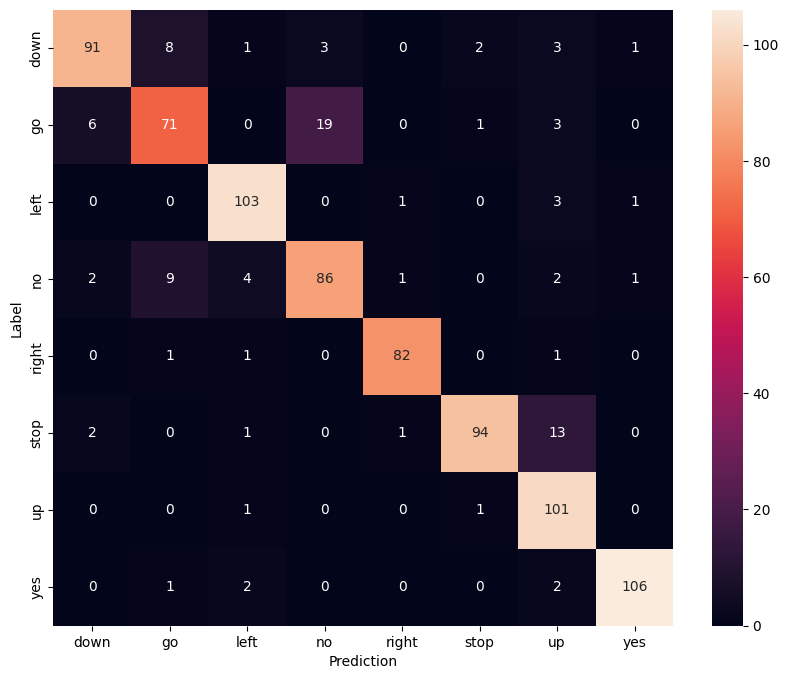

In [19]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Text(0, 0.5, 'Accuracy [%]')

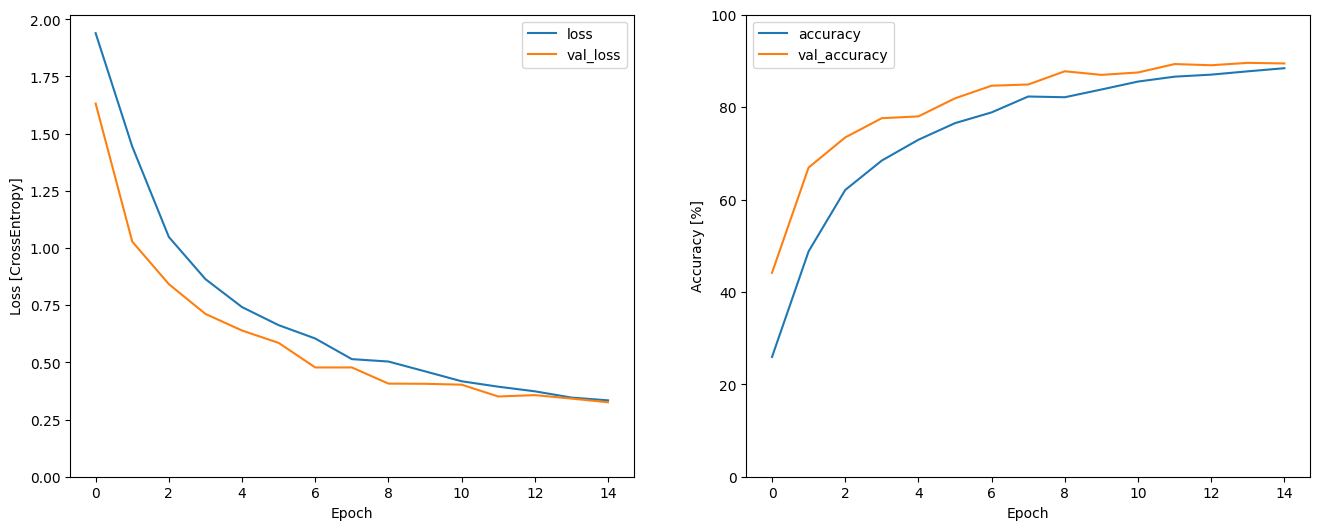

In [20]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

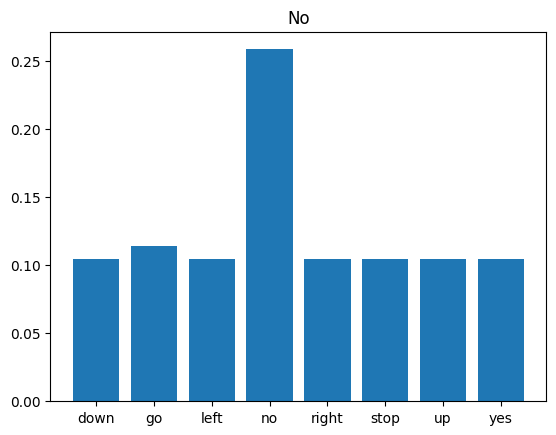

In [21]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Task2_Convolutional Autoencoder
* Test Accuracy: 0.824

In [22]:
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

# 实例化归一化层，并根据训练数据适配
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# 编码器输入
encoder_input = layers.Input(shape=input_shape)

# 归一化层应用在输入上
x = norm_layer(encoder_input)

# 编码器层，增加Batch Normalization和提高L2正则化系数
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.003))(x)
#x = layers.BatchNormalization()(x)  # 添加Batch Normalization层
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.003))(x)
#x = layers.BatchNormalization()(x)  # 添加Batch Normalization层
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# 解码器层
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# 分类器层，增加额外的Dense层
x = layers.Flatten()(encoded)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.003))(x)  # 更大的层
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.003))(x)  # 新增加的层
x = layers.Dropout(0.5)(x)  # 新增加的Dropout层
classifier_output = layers.Dense(num_labels, activation='softmax')(x)


# 自编码器模型
autoencoder = models.Model(encoder_input, decoded)

# 最终的模型，包含分类器
final_model = models.Model(encoder_input, classifier_output)

# 学习率衰减
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
)

In [23]:
# 编译模型
final_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# 回调函数，比如早停（Early Stopping）和模型检查点（Model Checkpoint）
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = callbacks.ModelCheckpoint(
    'best_model',
    save_best_only=True,
    monitor='val_loss',
    save_format='tf'  # 明确指定保存格式为 TensorFlow SavedModel
)

history = final_model.fit(
    train_spectrogram_ds,
    epochs=20,
    validation_data=val_spectrogram_ds,
    callbacks=[early_stopping, model_checkpoint]
)

# 加载性能最好的模型
final_model = tf.keras.models.load_model('best_model')  # 更改加载模型的方式

# 评估模型在测试集上的性能
test_loss, test_accuracy = final_model.evaluate(test_spectrogram_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 如果需要，你可以使用测试集的预测结果
predictions = final_model.predict(test_spectrogram_ds)


Epoch 1/20
100/100 [==============================] - 14s 96ms/step - loss: 3.1229 - accuracy: 0.2636 - val_loss: 2.3006 - val_accuracy: 0.5846
Epoch 2/20
100/100 [==============================] - 11s 106ms/step - loss: 2.0967 - accuracy: 0.5197 - val_loss: 1.7066 - val_accuracy: 0.7227
Epoch 3/20
100/100 [==============================] - 9s 90ms/step - loss: 1.7398 - accuracy: 0.6378 - val_loss: 1.4539 - val_accuracy: 0.7891
Epoch 4/20
100/100 [==============================] - 9s 93ms/step - loss: 1.5497 - accuracy: 0.7077 - val_loss: 1.3586 - val_accuracy: 0.8021
Epoch 5/20
100/100 [==============================] - 9s 94ms/step - loss: 1.4157 - accuracy: 0.7536 - val_loss: 1.2912 - val_accuracy: 0.7982
Epoch 6/20
100/100 [==============================] - 7s 67ms/step - loss: 1.3686 - accuracy: 0.7627 - val_loss: 1.3180 - val_accuracy: 0.8164
Epoch 7/20
100/100 [==============================] - 13s 131ms/step - loss: 1.2675 - accuracy: 0.7977 - val_loss: 1.2734 - val_accuracy: 0

Text(0, 0.5, 'Accuracy [%]')

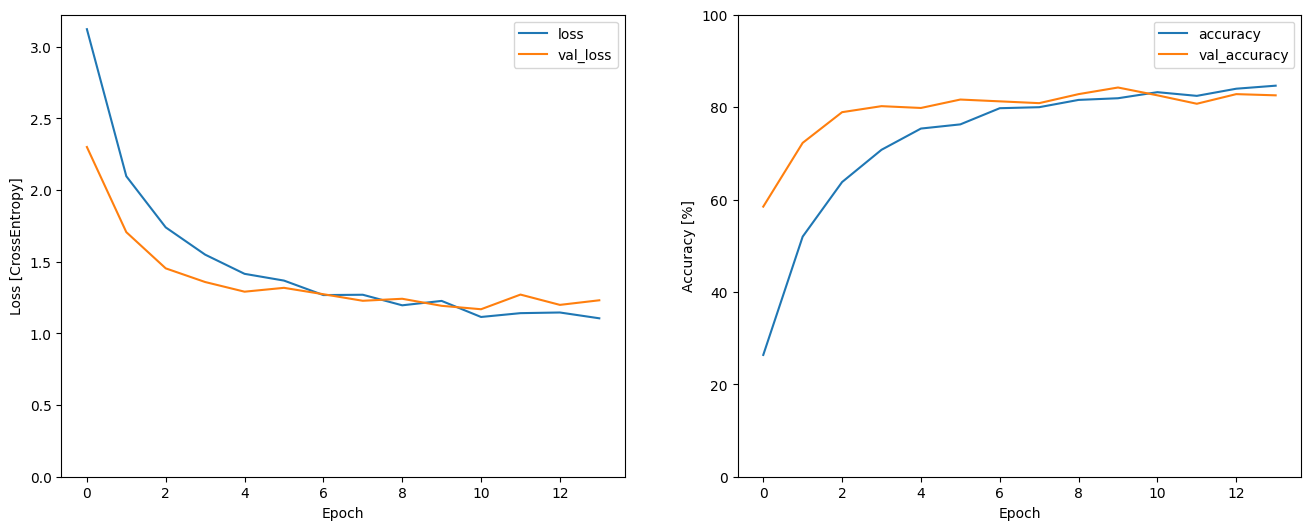

In [24]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Task2_DNN
* Test Accuracy: 0.8

In [25]:
def extract_mfcc(file_path, sr=16000, n_mfcc=20, mfcc_max_length=44):
    # 加载音频文件
    audio, _ = librosa.load(file_path, sr=sr)

    # 计算 MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # 计算 MFCC 的一阶差分（delta）和二阶差分（delta-delta）
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

    # 确保所有特征长度一致
    def pad_or_truncate(mfcc_feature, max_length):
        if mfcc_feature.shape[1] < max_length:
            pad_width = max_length - mfcc_feature.shape[1]
            mfcc_feature = np.pad(mfcc_feature, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc_feature = mfcc_feature[:, :max_length]
        return mfcc_feature

    mfccs = pad_or_truncate(mfccs, mfcc_max_length)
    mfccs_delta = pad_or_truncate(mfccs_delta, mfcc_max_length)
    mfccs_delta2 = pad_or_truncate(mfccs_delta2, mfcc_max_length)

    return mfccs, mfccs_delta, mfccs_delta2

# 遍历数据集目录并提取每个音频文件的 MFCC 特征及其标签
mfcc_features = []
for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file)
            mfccs, mfccs_delta, mfccs_delta2 = extract_mfcc(file_path)
            label = subdir  # 使用子目录名称作为标签
            mfcc_features.append((mfccs, mfccs_delta, mfccs_delta2, label))


In [26]:
# 准备特征和标签
X = []
y = []

for mfccs, mfccs_delta, mfccs_delta2, label in mfcc_features:
    # 将三个特征沿最后一个维度堆叠
    combined_features = np.stack((mfccs, mfccs_delta, mfccs_delta2), axis=-1)
    X.append(combined_features)
    y.append(label)

# 将列表转换为 NumPy 数组
X = np.array(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
# 将整数标签转换为独热编码
y = to_categorical(y, num_classes=8)

In [27]:
# 查看 LabelEncoder 转换的类别
class_labels = label_encoder.classes_
print("Label Encoder classes:", class_labels)

# 创建一个字典，映射原始标签到它们在 one-hot 编码中的索引
label_to_index = {label: index for index, label in enumerate(class_labels)}
print("Label to Index Mapping:", label_to_index)

Label Encoder classes: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Label to Index Mapping: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'right': 4, 'stop': 5, 'up': 6, 'yes': 7}


In [28]:
input_shape = X[0].shape
model = models.Sequential([
    layers.Flatten(input_shape=input_shape),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # 增加了Dropout概率
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # 增加了Dropout概率
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(8, activation='softmax')  # 假设有8个类别
])


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss= 'categorical_crossentropy', metrics=['accuracy'])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化两个独立的 StandardScaler 对象，一个用于训练数据，一个用于测试数据
scaler_train = StandardScaler()
scaler_test = StandardScaler()

# 为了标准化，我们需要重新整理数组的形状
# 假设 mfccs, mfccs_delta, mfccs_delta2 是三维数组（时间步长, MFCC特征, 通道）
X_train_reshaped = np.reshape(X_train, newshape=(-1, X_train.shape[2]))
X_test_reshaped = np.reshape(X_test, newshape=(-1, X_test.shape[2]))

# 计算标准化参数（仅使用训练数据）
scaler_train.fit(X_train_reshaped)

# 应用标准化到训练数据和测试数据
X_train_scaled = scaler_train.transform(X_train_reshaped)
X_test_scaled = scaler_test.fit_transform(X_test_reshaped)  # 注意这里使用不同的缩放器

# 将标准化后的数据重新整理为原始形状
X_train_scaled = np.reshape(X_train_scaled, newshape=X_train.shape)
X_test_scaled = np.reshape(X_test_scaled, newshape=X_test.shape)

# 早停设置
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True  # 恢复最佳权重
)
# 训练模型
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,  # 迭代次数，可根据需要调整
    batch_size=64,  # 批处理大小，根据你的系统资源进行调整
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
100/100 [==============================] - 6s 19ms/step - loss: 3.2122 - accuracy: 0.3156 - val_loss: 2.5300 - val_accuracy: 0.4975
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 2.4116 - accuracy: 0.5131 - val_loss: 1.9655 - val_accuracy: 0.6550
Epoch 3/50
100/100 [==============================] - 1s 7ms/step - loss: 2.0286 - accuracy: 0.6025 - val_loss: 1.7859 - val_accuracy: 0.6787
Epoch 4/50
100/100 [==============================] - 1s 7ms/step - loss: 1.8199 - accuracy: 0.6475 - val_loss: 1.5975 - val_accuracy: 0.7250
Epoch 5/50
100/100 [==============================] - 1s 14ms/step - loss: 1.6906 - accuracy: 0.6711 - val_loss: 1.4942 - val_accuracy: 0.7375
Epoch 6/50
100/100 [==============================] - 2s 15ms/step - loss: 1.5847 - accuracy: 0.6945 - val_loss: 1.5332 - val_accuracy: 0.7106
Epoch 7/50
100/100 [==============================] - 1s 11ms/step - loss: 1.4970 - accuracy: 0.7180 - val_loss: 1.3416 - val_accuracy: 0.7638
Ep

Text(0, 0.5, 'Accuracy [%]')

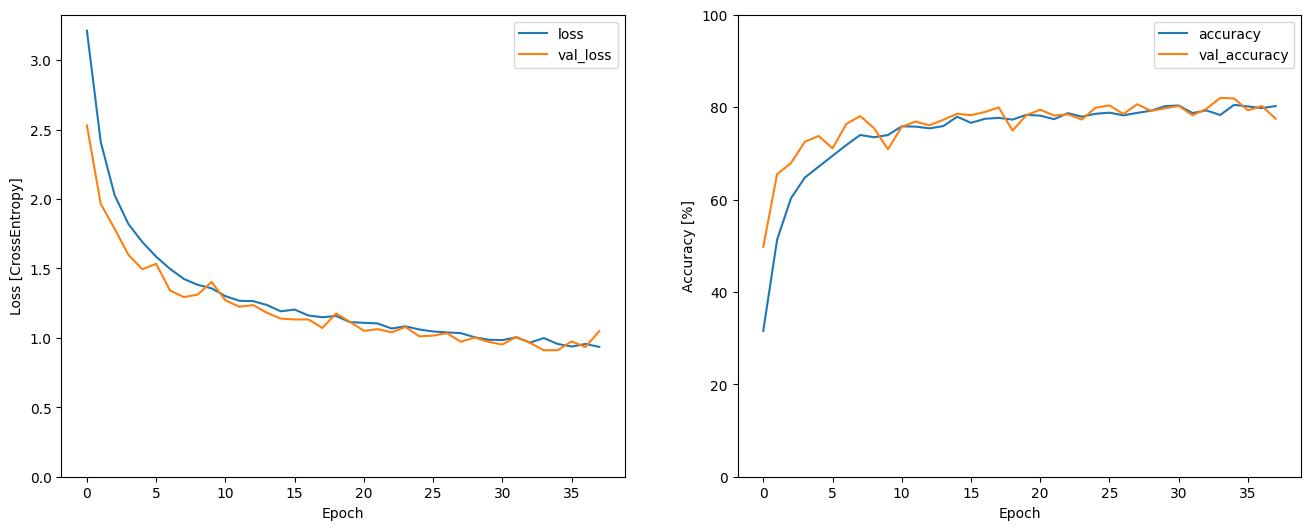

In [30]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [31]:
# 尝试专注训练但失败

In [32]:
# # 'go', 'no', 和 'down' 在 one-hot 编码中的索引
# target_indices = [0, 1, 3]

# # 筛选出包含这些单词的训练样本
# target_samples = np.any(y_train[:, target_indices] == 1, axis=1)
# X_train_focused = X_train_scaled[target_samples]
# y_train_focused = y_train[target_samples]

In [33]:
# # 进行专注训练
# focused_epochs = 5  # 设置专注训练的迭代次数
# model.fit(X_train_focused, y_train_focused, epochs=focused_epochs, batch_size=64)

In [34]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

50/50 [==============================] - 0s 3ms/step - loss: 0.9107 - accuracy: 0.8200
Test accuracy: 0.8199999928474426
Test loss: 0.9106570482254028


50/50 [==============================] - 0s 3ms/step


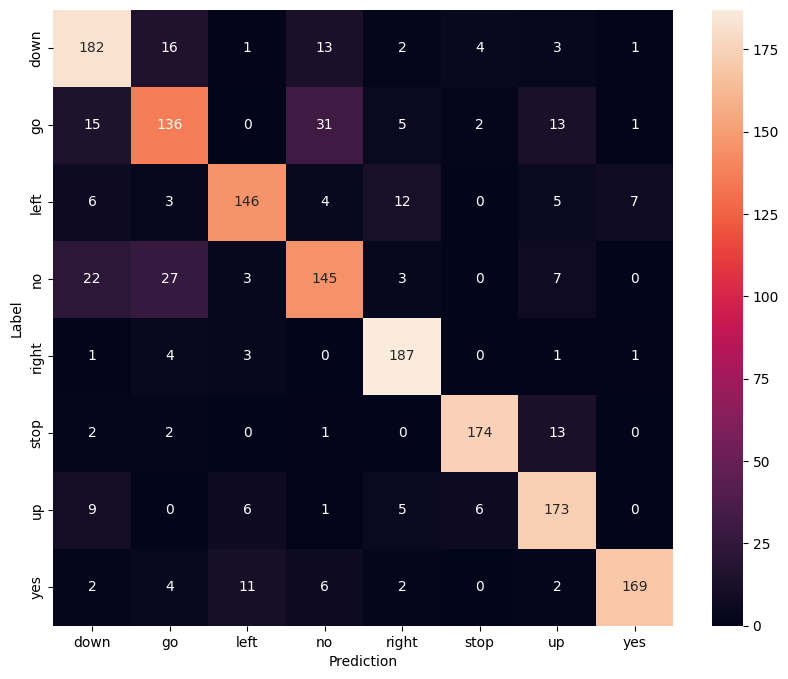

In [35]:
# 使用模型对X_test_scaled进行预测
y_pred = model.predict(X_test_scaled)

# 将预测结果转换为类别标签
y_pred = tf.argmax(y_pred, axis=1)

# 如果y_test已经是one-hot编码，您需要将其转换为类别标签
y_true = tf.argmax(y_test, axis=1)

# 生成混淆矩阵
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=['down' ,'go' ,'left', 'no' ,'right' ,'stop', 'up' ,'yes'],
            yticklabels=['down' ,'go' ,'left', 'no' ,'right' ,'stop', 'up' ,'yes'],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()